In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 12})

In [2]:
def foo_k_r(T):
    return k_r0 * math.e**(-E_a/(R_u*T))

In [3]:
def foo_k(T, gas_name):
    if gas_name == 'H2':
        a0 = 0.3975
        a1 = 0.4814/10**4
        a2 = -1.073/10**7
        a3 = 4.6863/10**11
        a4 = -8.5361/10**15
        a5 = 5.6934/10**19
    elif gas_name == 'O2':
        a0 = 0.4697
        a1 = -2.9819/10**4
        a2 = 2.0320/10**7
        a3 = -7.1938/10**11
        a4 = 12.311/10**15
        a5 = -8.0736/10**19
    elif gas_name == 'H2O':
        a0 = 0.3834
        a1 = -1.8579/10**4
        a2 = 0.6266/10**7
        a3 = -1.0528/10**11
        a4 = 0.93554/10**15
        a5 = -0.38512/10**19
    else:
        print('Houston we have a problem')
    return 1 + a0 + a1*T + a2*T**2 + a3*T**3 + a4*T**4 + a5*T**5

In [286]:
def foo_alpha(r):
    if r >= 0.000001:
        a = 1 - math.e**(-r)
        return (1-a/r)/a
    else:
        return 0.5

In [287]:
# параметры установки
d = 45*10**(-3) # калибр
S = math.pi*d**2/4 # площадь
W_0 = 0.005 # объем каморы
l_d = 4.5 # длина ствола
m_elem = 0.52 # масса МЭ
p_f = 150 * 10**6 # давление форсирования
k_r0 = 9.87 * 10**8 # предэскп. множитель 

Q_t = 13.4 * 10**6 # энергия образования 1 кг продуктов реакций 
# E_ign = 0.5*10**6 # энергия воспламенителя
E_ign = 0*10**6 # энергия воспламенителя
E_a = 60*10**3 # энергия активации

v_p0 = 0 # начальная скорость
x_p0 = 0 # начальная координата
p_a = 10**5 # атмосфэрное давление

In [324]:
p_0 = 44.5 * 10**6 # начальное давление
T_0 = 300 # начальная температура
R_u = 8.31446262 # универсальная газовая постоянная
hi_O2_and_H2_0 = 1/8 # начальное соотношение мольных долей

In [325]:
mu_H2 = 2*10**(-3) # молярная масса водорода
mu_O2 = 16*10**(-3) # молярная масса кислорода
mu_H2O = 18*10**(-3) # молярная масса воды

In [326]:
# термодинамика
# R = foo_k_r * () # универсальная газовая постоянная
# m_g_0 = (2*mu_H2+mu_O2) * R_u * T_0/ (p_0 * W_0)
# print(m_g_0)
# rho_0 = m_g_0/W_0
# rho_0 = p_0/(R_u*T_0) # начальная плотность газа
# m_g_0 = rho_0*W_0 # начальная масса газа

# hi_O2_and_H2_0 = 8 # начальное соотношение мольных долей
# ratio_m_O2_and_m_H2_0 = hi_O2_and_H2_0*mu_O2/mu_H2 # начальное соотношение масс газа через мольные доли, скрин "мольные доли.png"

# m_H2_0 = m_g_0 / (ratio_m_O2_and_m_H2_0+1) # начальная масса водорода
# m_O2_0 = m_H2_0 * ratio_m_O2_and_m_H2_0 # начальная масса кислорода

# n_H2_0 = m_H2_0/mu_H2 # начальное количества вещества водорода
# n_O2_0 =  m_O2_0/mu_O2 # начальное количества вещества кислорода

# С_H2_0 = n_H2_0/W_0 # начальная молярная концентрация водорода
# С_O2_0 = n_O2_0/W_0 # начальная молярная концентрация кислорода

# C_H2O_0 = 0 # нет продуктов реакции в начальный момент времени

In [327]:
# n_smesi = p_0 * W_0/(R_u * T_0)
# m_O2_0 = n_smesi * mu_O2 / (hi_O2_and_H2_0 * mu_O2/mu_H2+1)
# m_H2_0 = n_smesi * mu_H2 - m_O2_0 / mu_O2 * mu_H2
# n_H2_0 = m_H2_0/mu_H2 # начальное количества вещества водорода
# n_O2_0 =  m_O2_0/mu_O2 # начальное количества вещества кислорода
# n_H2O_0 = 0 # начальное количества вещества воды

In [328]:
n_smesi = p_0 * W_0/(R_u * T_0)

n_H2_0 = n_smesi/(hi_O2_and_H2_0+1)# начальное количества вещества водорода
n_O2_0 =  n_H2_0 * hi_O2_and_H2_0  # начальное количества вещества кислорода
n_H2O_0 = 0 # начальное количества вещества воды

m_O2_0 = n_O2_0*mu_O2
m_H2_0 = n_H2_0*mu_H2

In [329]:
С_H2_0 = n_H2_0/W_0 # начальная молярная концентрация водорода
С_O2_0 = n_O2_0/W_0 # начальная молярная концентрация кислорода
C_H2O_0 = 0 # нет продуктов реакции в начальный момент времени

In [330]:
help_value_T_0 = (n_H2_0/(foo_k(T_0,'H2')-1) + n_O2_0/(foo_k(T_0,'O2')-1) + n_H2O_0/(foo_k(T_0,'H2O')-1))**(-1)
k_smesi_T_0 = 1 + n_H2_0*help_value_T_0 + n_O2_0*help_value_T_0 + n_H2O_0*help_value_T_0 # показатель адиабаты смеси для формулы 4.5

In [331]:
tau = 0 # время от начала процесса
C_n_1 = np.array([С_H2_0, С_O2_0, C_H2O_0]) # начальный вектор C
P_n = np.array([0, 0, foo_k_r(T_0)*C_n_1[0]*C_n_1[1]**(1/2)]) # начальный вектор Р
D_n = np.array([foo_k_r(T_0)*C_n_1[1]**(1/2), 1/2*foo_k_r(T_0)*C_n_1[0]*C_n_1[1]**(-1/2),0]) # начальный вектор D
W_n_1 = W_0 # начальный объем
v_p = v_p0 # начальная скорость

tau_arr = []
C_H2_arr = []
C_O2_arr = []
C_H2O_arr = []
m_H2_arr = []
m_O2_arr = []
m_H2O_arr = []
v_p_arr = []
p_m_arr = []
x_p_arr = []
M_p_arr = []
# rho_arr = []
T_arr = []

tau_arr = np.array(tau_arr)
C_H2_arr = np.array(C_H2_arr)
C_O2_arr = np.array(C_O2_arr)
C_H2O_arr = np.array(C_H2O_arr)
m_H2_arr = np.array(m_H2_arr)
m_O2_arr = np.array(m_O2_arr)
m_H2O_arr = np.array(m_H2O_arr)
v_p_arr = np.array(v_p_arr)
p_m_arr = np.array(p_m_arr)
x_p_arr = np.array(x_p_arr)
M_p_arr = np.array(M_p_arr)
# rho_arr = np.array(rho_arr)
T_arr = np.array(T_arr)

dt=1e-9
x_p = x_p0
T = T_0

schetchik=0
falg_fors=0
while x_p <= l_d: # условие цикла, пока МЭ не покинул дульный срез
    schetchik+=1
    tau += dt # время от начала процесса
#     tau_arr = np.append(tau_arr, tau)
    
    C_n = C_n_1 # вектор С
#     C_H2_arr = np.append(C_H2_arr, C_n[0])
#     C_O2_arr = np.append(C_O2_arr, C_n[1])
#     C_H2O_arr = np.append(C_H2O_arr, C_n[2])
    
    W_n = W_n_1
    
    n_H2 = C_n[0] * W_n # количество вещества водорода
    n_O2 = C_n[1] * W_n # количество вещества кислорода
    n_H2O = C_n[2] * W_n  # количество вещества воды
    
    m_H2 = n_H2 * mu_H2 # масса водорода
    m_O2 = n_O2 * mu_O2 # масса кислорода
    m_H2O = n_H2O * mu_H2O # масса воды
#     m_H2_arr = np.append(m_H2_arr, m_H2)
#     m_O2_arr = np.append(m_O2_arr, m_O2)
#     m_H2O_arr = np.append(m_H2O_arr, m_H2O)
    n_smesi = n_H2 + n_O2 + n_H2O # количество вещества смеси
   

    P_n = np.array([0, 0, foo_k_r(T)*C_n[0]*C_n[1]**(1/2)]) # вектор P
    D_n = np.array([foo_k_r(T)*C_n[1]**(1/2), 1/2*foo_k_r(T)*C_n[0]*C_n[1]**(-1/2),0]) # вектор D

    M_p = mu_H2O * C_n[2] * W_n # масса продуктов реакции
#     M_p_arr = np.append(M_p_arr, M_p)

    phi = (1+(m_H2 + m_O2 + m_H2O)/(3*m_elem)) # фиктивность, масса всего
    
    # расчет показателя адиабаты смеси
    help_value = (n_H2/(foo_k(T,'H2')-1) + n_O2/(foo_k(T,'O2')-1) + n_H2O/(foo_k(T,'H2O')-1))**(-1)
    k_smesi = 1 + n_H2*help_value + n_O2*help_value + n_H2O*help_value # показатель адиабаты смеси для формулы 4.5
    
    p_m = (k_smesi-1)/W_n * ((p_0*W_0)/(k_smesi_T_0-1) + Q_t*M_p - E_ign - phi/2*m_elem*v_p**2) # среднебаллистическое давление

    #     p_m_arr = np.append(p_m_arr, p_m)

    T = p_m*W_n/(R_u*n_smesi)
#     T_arr = np.append(T_arr,T)

    if p_m <= p_f and falg_fors == 0:
        dv_p = 0
        
    elif p_m <= p_f and falg_fors == 1:
        dv_p = (p_m - p_a)*S/(phi*m_elem) * dt
        
    elif  p_m > p_f:
        falg_fors = 1
        dv_p = (p_m - p_a)*S/(phi*m_elem) * dt # диф. скорости МЭ
    
#     dv_p = (p_m - p_a)*S/(phi*m_elem) * dt # диф. скорости МЭ
    
    v_p += dv_p # скорость МЭ
#     v_p_arr = np.append(v_p_arr, v_p)

    dx_p = v_p * dt # диф. координаты МЭ
    
    x_p += dx_p  # координата МЭ
#     x_p_arr = np.append(x_p_arr, x_p)
    
    W_n_1 = W_0 + x_p*S  # Заснарядный объем на n+1 шаге
    
    W_n = W_0 + (x_p-dx_p)*S # Заснарядный объем на n шаге
           
    foo_alpha_res = np.array([0,0,0]) # значение умножения алфа функции от произведения вектора D на dt, 
    for i in range(len(D_n)):
        foo_alpha_res[i] = foo_alpha(D_n[i]*dt)
        
    C_n_kr = W_n/W_n_1 * (C_n + (dt *(P_n-C_n*D_n))/(1+foo_alpha_res*D_n*dt)) # Предиктор вектора С
   
    if C_n_kr[1]>=1e-1:
        D_n_kr = (np.array([foo_k_r(T)*C_n_kr[1]**(1/2), 1/2*foo_k_r(T)*C_n_kr[0]*C_n_kr[1]**(-1/2),0]) + D_n)/2 # Предиктор вектора D
    else:
         D_n_kr = np.array([0,0,0])
            
    foo_alpha_res = np.array([0,0,0]) # значение умножения алфа функции от произведения вектора D на dt, 
    for i in range(len(D_n_kr)):
        foo_alpha_res[i] = foo_alpha(D_n_kr[i]*dt)
    
    if C_n_kr[1]>=1e-1:
        P_n_kr = foo_alpha_res*np.array([0, 0, foo_k_r(T)*C_n_kr[0]*C_n_kr[1]**(1/2)]) + (1-foo_alpha_res)*P_n # Предиктор вектора P    
    else:
        P_n_kr = np.array([0, 0, 0])
    C_n_1 = W_n/W_n_1 * (C_n + (dt *(P_n_kr-C_n*D_n_kr))/(1+foo_alpha_res*D_n_kr*dt)) # Корректор вектора С
    
    if schetchik % 10_000 == 0:
        tau_arr = np.append(tau_arr, tau)
        x_p_arr = np.append(x_p_arr, x_p)
        C_H2_arr = np.append(C_H2_arr, C_n[0])
        C_O2_arr = np.append(C_O2_arr, C_n[1])
        C_H2O_arr = np.append(C_H2O_arr, C_n[2])
        m_H2_arr = np.append(m_H2_arr, m_H2)
        m_O2_arr = np.append(m_O2_arr, m_O2)
        m_H2O_arr = np.append(m_H2O_arr, m_H2O)
        M_p_arr = np.append(M_p_arr, M_p)
        v_p_arr = np.append(v_p_arr, v_p)
        T_arr = np.append(T_arr,T)
        p_m_arr = np.append(p_m_arr, p_m)
    if schetchik % 100_000 == 0:
        print(tau, x_p, p_m/10**6, C_n)

0.00010000000000013679 0.0 44.75257111948799 [1.58554665e+04 1.98093348e+03 2.66622960e+00]
0.0001999999999992999 0.0 45.04489808268989 [1.58523791e+04 1.97938976e+03 5.75366115e+00]
0.000299999999999678 0.0 45.39101504174473 [1.58487214e+04 1.97756092e+03 9.41132906e+00]
0.00040000000000125254 0.0 45.813787489356606 [1.58442505e+04 1.97532547e+03 1.38822287e+01]
0.0005000000000028271 0.0 46.354168550784046 [15838.53074728  1972.46559781    19.6019677 ]
0.0006000000000044016 0.0 47.09681606778847 [15830.66061156  1968.53052992    27.47208879]
0.0007000000000059761 0.0 48.265928892698376 [15818.24844371  1962.32444592    39.88422131]
0.0008000000000075506 0.0 50.931238100112616 [15789.84480467  1948.12262596    68.28767595]


C:\Users\Stepan\AppData\Local\Temp\ipykernel_9204\3116941642.py:67: RuntimeWarning: invalid value encountered in double_scalars
  P_n = np.array([0, 0, foo_k_r(T)*C_n[0]*C_n[1]**(1/2)]) # вектор P
C:\Users\Stepan\AppData\Local\Temp\ipykernel_9204\3116941642.py:68: RuntimeWarning: invalid value encountered in double_scalars
  D_n = np.array([foo_k_r(T)*C_n[1]**(1/2), 1/2*foo_k_r(T)*C_n[0]*C_n[1]**(-1/2),0]) # вектор D


0.0009000000000091252 0.0006401953352503655 232.95316271794326 [12098.89014391 -1245.87999081  2961.05969849]
0.0010000000000081586 0.006419464581435684 232.43473045483375 [12076.69423348 -1243.59437285  2955.62751297]
0.0010999999999988911 0.018196581225540263 231.3847160261789 [12031.71383703 -1238.9625285   2944.61909504]
0.0011999999999896236 0.03594446652572816 229.81854873836053 [11964.55853987 -1232.04722966  2928.18363348]
0.0012999999999803561 0.05962272986144193 227.7588151460944 [11876.12214241 -1222.94051518  2906.53987531]
0.0013999999999710887 0.08917825018200987 225.23444907874193 [11767.55223039 -1211.7605574   2879.96867852]
0.0014999999999618212 0.12454592093898573 222.2797335926694 [11640.21255438 -1198.64778817  2848.80380487]
0.0015999999999525537 0.16564953286675668 218.9331771158232 [11495.64047945 -1183.76051725  2813.4215062 ]
0.0016999999999432862 0.21240276573396125 215.23632904672633 [11335.50189021 -1167.27028867  2774.229488  ]
0.0017999999999340187 0.2647

In [332]:
len(tau_arr)

519

In [333]:
v_p

1747.6529854086339

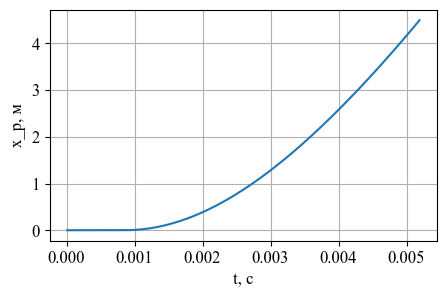

In [334]:
plt.figure(figsize=(5,3))
plt.plot(tau_arr, x_p_arr)
plt.xlabel('t, с')
plt.ylabel('x_p, м')
plt.grid()

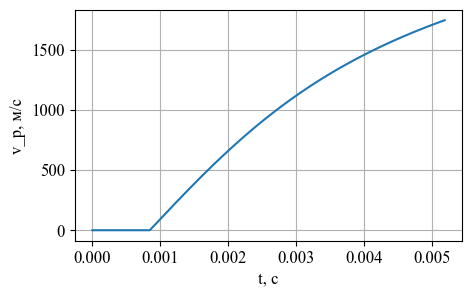

In [335]:
plt.figure(figsize=(5,3))
plt.plot(tau_arr, v_p_arr)
plt.xlabel('t, с')
plt.ylabel('v_p, м/с')
plt.grid()

In [336]:
m_H2_arr, m_O2_arr, m_H2O_arr

(array([0.15857882, 0.15857628, 0.15857371, 0.1585711 , 0.15856845,
        0.15856577, 0.15856305, 0.1585603 , 0.1585575 , 0.15855467,
        0.15855179, 0.15854887, 0.1585459 , 0.15854289, 0.15853983,
        0.15853673, 0.15853357, 0.15853036, 0.1585271 , 0.15852379,
        0.15852042, 0.15851699, 0.1585135 , 0.15850995, 0.15850634,
        0.15850266, 0.15849891, 0.15849508, 0.15849119, 0.15848721,
        0.15848316, 0.15847902, 0.1584748 , 0.15847049, 0.15846608,
        0.15846158, 0.15845698, 0.15845227, 0.15844744, 0.1584425 ,
        0.15843745, 0.15843226, 0.15842694, 0.15842148, 0.15841587,
        0.1584101 , 0.15840417, 0.15839807, 0.15839179, 0.15838531,
        0.15837862, 0.15837172, 0.15836459, 0.1583572 , 0.15834955,
        0.15834162, 0.15833339, 0.15832482, 0.15831591, 0.15830661,
        0.15829689, 0.15828673, 0.15827607, 0.15826487, 0.15825307,
        0.15824061, 0.15822742, 0.15821341, 0.15819847, 0.15818248,
        0.1581653 , 0.15814673, 0.15812656, 0.15

In [337]:
# p_m зависит от v_p, v_p зависит от dv_p, что зависит от dt

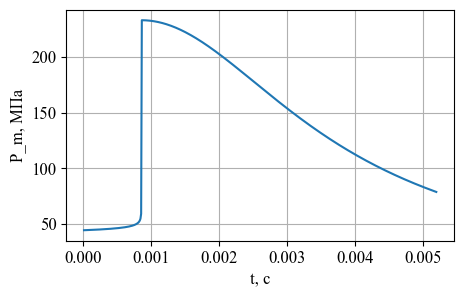

In [338]:
plt.figure(figsize=(5,3))
plt.plot(tau_arr, p_m_arr/10**6)
plt.xlabel('t, с')
plt.ylabel('P_m, МПа')
plt.grid()

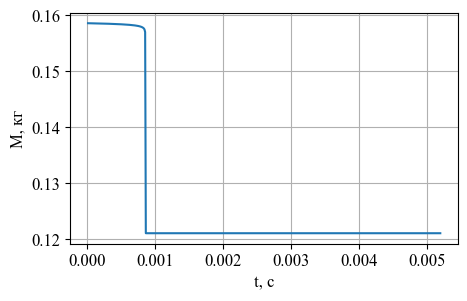

In [339]:
plt.figure(figsize=(5,3))
plt.plot(tau_arr, m_H2_arr)
plt.xlabel('t, с')
plt.ylabel('M, кг')
plt.grid()

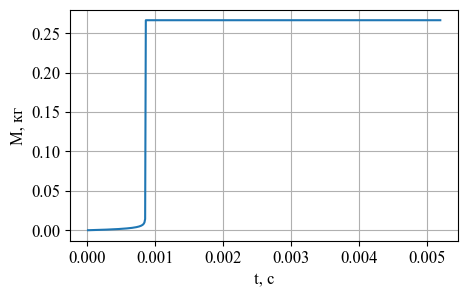

In [340]:
plt.figure(figsize=(5,3))
plt.plot(tau_arr, M_p_arr)
plt.xlabel('t, с')
plt.ylabel('M, кг')
plt.grid()

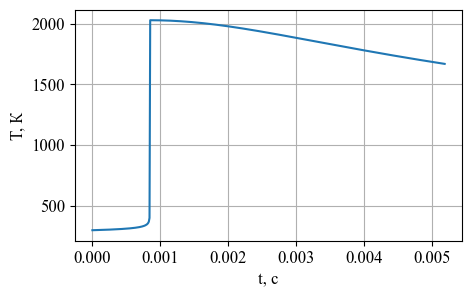

In [341]:
plt.figure(figsize=(5,3))
plt.plot(tau_arr, T_arr)
plt.xlabel('t, с')
plt.ylabel('T, К')
plt.grid()